In [7]:
import os
import json
#import torch
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from numpy.linalg import inv
import tensorflow as tf
import glob
import cv2

sway_folder = "/home/jovyan/data/metrabs-processed/sway"
root = f"{sway_folder}/sway61769"
variant_root = f"{sway_folder}/sway_test_variants"

### Get all video folder names. Don't us os.listdir(root) because it is too slow
with open(f"{sway_folder}/test.txt", "r") as f:
    vidnames = [line.strip() for line in f.readlines()]

In [2]:
##### IMPORTANT! This is the joint order information!!! It follows human3.6m
joint_names = np.array(['pelv', 'rhip', 'rkne', 'rank', 'lhip', 'lkne', 'lank', 'spin', 'neck', 'head', 'htop', 'lsho', 'lelb', 'lwri', 'rsho', 'relb', 'rwri'])
joint_edges = np.array([ [ 9, 10],
                         [ 9,  8],
                         [ 6,  5],
                         [12, 11],
                         [12, 13],
                         [ 4,  5],
                         [ 4,  0],
                         [11,  8],
                         [ 8, 14],
                         [ 8,  7],
                         [ 0,  1],
                         [ 0,  7],
                         [ 3,  2],
                         [15, 14],
                         [15, 16],
                         [ 1,  2]])

In [124]:
def visualize(image, keypoint_2d, pose3d, bbox=None, _keypoint_2d=None):
    h, w, _ = image.shape
    plt.clf()
    fig = plt.figure(figsize=(16, 5))
    image_ax = fig.add_subplot(1, 4, 1)
    image_ax.imshow(image)
    
    for jj, (i_start, i_end) in enumerate(joint_edges):
        image_ax.plot(*zip(keypoint_2d[i_start], keypoint_2d[i_end]), marker='o', markersize=2)
    image_ax.scatter(*keypoint_2d.T, s=3)
    
    if _keypoint_2d is not None:
        for kpt in _keypoint_2d:
            image_ax.plot(kpt[0], kpt[1], marker='o', color='cyan', markersize=2)
        
    if bbox is not None:
        min_x = bbox[0]
        min_y = bbox[1]
        max_x = bbox[0] + bbox[2]
        max_y = bbox[1] + bbox[3]
        image_ax.plot([min_x, max_x, max_x, min_x, min_x], [min_y, min_y, max_y, max_y, min_y])

    deg = 5
    views = [(deg, deg - 90), (deg, deg), (90 - deg, deg - 90)]
    _pose3d = pose3d.copy()
    _pose3d[..., 1], _pose3d[..., 2] = _pose3d[..., 2], - _pose3d[..., 1]
    for vv, view in enumerate(views):
        pose_ax = fig.add_subplot(1, 4, vv + 2, projection='3d')
        pose_ax.view_init(*view)
        pose_ax.set_xlim3d(-1000, 1000)
        pose_ax.set_zlim3d(-1000, 1000)
        pose_ax.set_ylim3d(800, 3000)
        
        for jj, (i_start, i_end) in enumerate(joint_edges):
            pose_ax.plot(*zip(_pose3d[i_start], _pose3d[i_end]), marker='o', markersize=2)
        pose_ax.scatter(*_pose3d.T, s=2)
    plt.show()
    return

4a4c3df2-73f9-42a9-891c-1655f0d64e23 00451
Max pixel difference: 0.08090066673230467


<Figure size 432x288 with 0 Axes>

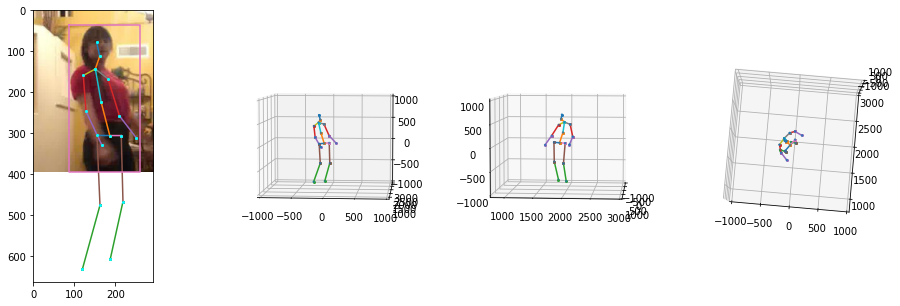

In [135]:
variants = ["landscape", "portrait", "tight"]
variant = np.random.choice(variants)
vidname = np.random.choice(vidnames)
video_folder = os.path.join(variant_root, variant, vidname)
imagefiles = [f for f in sorted(os.listdir(os.path.join(portrait_folder, "images"))) if f.endswith(".jpg")]

pose3d = np.load(os.path.join(video_folder, "metrab_annotations", "poses3d.npy"), allow_pickle=True).item()
pose2d = np.load(os.path.join(video_folder, "metrab_annotations", "poses2d.npy"), allow_pickle=True).item()
bbox = np.load(os.path.join(video_folder, "metrab_annotations", "bbox.npy"), allow_pickle=True).item()
intrinsics = np.load(os.path.join(video_folder, "metrab_annotations", "intrinsics.npy"), allow_pickle=True).item()
extrinsics = np.load(os.path.join(video_folder, "metrab_annotations", "extrinsics.npy"), allow_pickle=True)

keys = list(pose3d.keys())
key = np.random.choice(keys)
image = plt.imread(os.path.join(video_folder, "images", key + ".jpg"))

print(vidname, key)
_pose2d = pose3d[key] / pose3d[key][..., -1:] @ intrinsics[key][:2].T
print("Max pixel difference:", np.max(np.abs(pose2d[key] - _pose2d)))

visualize(image, pose2d[key], pose3d[key], bbox[key], _pose2d)